
# RL Agent for **Volatility 10 Index** (DayByDay96) — Research Notebook

This notebook is tailored to your dataset: **`DayByDay96_Volatility 10 Index.csv`** where each row contains **96 past timestamps** of prices (close values), representing a sliding window.  
We build a **row-wise RL environment**: each environment step moves from row *t* → row *t+1*, where the **observation** is the full 96-length window at *t*, and the **reward** is the PnL from the change in the **last price** of row *t* to the last price of row *t+1*, minus costs (spread/commission/slippage).

> ⚠️ Research/education only. Markets (and synthetic indices) are non-stationary. Use strict out-of-sample evaluation and realistic costs.


In [1]:

# If needed (local environment), uncomment:
!pip install numpy pandas matplotlib gymnasium stable-baselines3 torch --quiet
!pip install tensorboard

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gymnasium as gym
from gymnasium import spaces

# Optional: Stable-Baselines3 (works if installed)
try:
    from stable_baselines3 import PPO
    from stable_baselines3.common.vec_env import DummyVecEnv
    from stable_baselines3.common.callbacks import EvalCallback
    SB3_AVAILABLE = True
except Exception as e:
    SB3_AVAILABLE = False
    print("Stable-Baselines3 not available. You can still use the custom env and baselines.\n", e)

plt.rcParams['figure.figsize'] = (10,4)


Defaulting to user installation because normal site-packages is not writeable


In [2]:

from pathlib import Path

DATA_PATH = Path("DayByDay96_Volatility 10 Index.csv")  # Adjust if running elsewhere

# The file has no header — 96 columns of numeric prices per row.
df96 = pd.read_csv(DATA_PATH, header=None).apply(pd.to_numeric, errors='coerce')
assert df96.shape[1] == 96, f"Expected 96 columns per row, got {df96.shape[1]}"
df96 = df96.dropna().reset_index(drop=True)

print("Shape (rows, 96):", df96.shape)
df96.head()


Shape (rows, 96): (3104, 96)


,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,10638.110,10631.070,10628.190,10621.786,10619.188,10611.001,10606.655,10607.089,10615.632,10618.086,...,10595.823,10591.983,10589.202,10587.826,10588.072,10585.104,10589.460,10592.680,10593.754,10586.740
1,10578.203,10573.419,10575.812,10578.518,10574.620,10571.834,10578.734,10570.069,10568.123,10558.300,...,10640.695,10637.778,10637.218,10636.383,10640.994,10635.212,10630.812,10633.830,10636.839,10634.908
2,10608.315,10607.277,10616.167,10619.425,10614.373,10609.166,10604.484,10601.993,10598.720,10601.924,...,10546.814,10553.559,10548.820,10558.001,10559.037,10557.556,10563.963,10561.558,10566.272,10574.881
3,10694.108,10690.400,10684.441,10689.490,10685.195,10687.493,10680.452,10690.194,10692.344,10697.278,...,10622.166,10619.307,10614.400,10612.311,10611.959,10612.127,10606.979,10599.329,10604.774,10606.364
4,10614.867,10611.875,10612.005,10605.755,10595.853,10600.612,10600.602,10602.418,10598.101,10595.486,...,10681.512,10685.474,10686.857,10688.388,10693.003,10687.538,10680.326,10691.505,10693.327,10702.350


Continuous series length: 3104


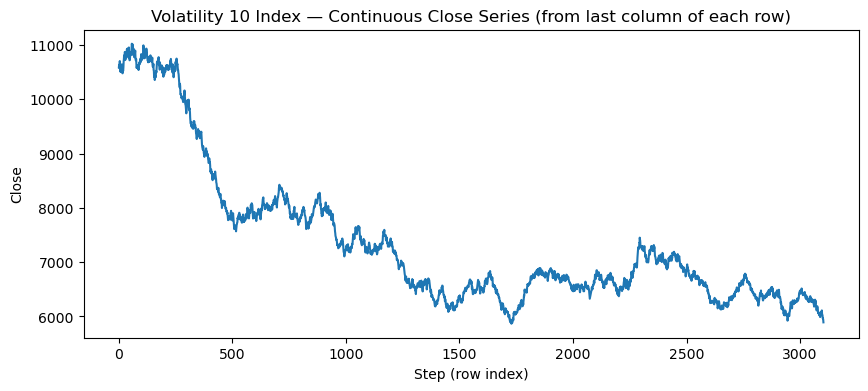

In [3]:

# Strategy: take the **last column** of each 96-length row as the "current close".
# This gives a continuous series if rows are ordered chronologically.
close_series = df96.iloc[:, -1].values.astype(float)

# Quick sanity checks & plot
print("Continuous series length:", len(close_series))
plt.plot(close_series)
plt.title("Volatility 10 Index — Continuous Close Series (from last column of each row)")
plt.xlabel("Step (row index)"); plt.ylabel("Close"); plt.show()


In [4]:

def _rsi(x, n=14):
    x = np.asarray(x, dtype=np.float64)
    diff = np.diff(x, prepend=x[0])
    gain = np.where(diff > 0, diff, 0.0)
    loss = np.where(diff < 0, -diff, 0.0)
    # Wilder's smoothing (approx via rolling mean here for simplicity)
    avg_gain = pd.Series(gain).rolling(n).mean().bfill().values
    avg_loss = pd.Series(loss).rolling(n).mean().bfill().values
    rs = np.divide(avg_gain, np.maximum(avg_loss, 1e-12))
    rsi = 100 - (100 / (1 + rs))
    return rsi

def _ema(x, n):
    alpha = 2/(n+1)
    y = np.empty_like(x, dtype=np.float64)
    y[0] = x[0]
    for i in range(1, len(x)):
        y[i] = alpha*x[i] + (1-alpha)*y[i-1]
    return y

def build_row_features(win):
    """win: shape (96,) — return compact features per window
    Features:
      - normalized log-returns (z-scored)
      - EMA(10)-EMA(50) over the window (last value)
      - RSI(14) (last value, scaled to [0,1])
      - rolling volatility of returns (last value)
    """
    w = np.asarray(win, dtype=np.float64)
    rets = np.diff(np.log(w + 1e-12), prepend=np.log(w[0]+1e-12))
    # Normalize window returns to be roughly stationary for the policy net
    mu, sd = rets.mean(), rets.std() + 1e-12
    rets_z = (rets - mu) / sd

    ema10 = _ema(w, 10)
    ema50 = _ema(w, 50)
    rsi14 = _rsi(w, 14) / 100.0
    vol20 = pd.Series(rets).rolling(20).std().bfill().values

    # Compact representation: stack 96 rets_z + 3 scalars (use last values)
    feat = np.concatenate([rets_z, [
        (ema10[-1] - ema50[-1]) / (sd * 10),  # scale diff to comparable magnitude
        rsi14[-1],
        vol20[-1]
    ]])
    return feat.astype(np.float32)

# Build feature matrix for all rows (except the very first if needed)
features = np.vstack([build_row_features(row) for _, row in df96.iterrows()])
features.shape


(3104, 99)

In [5]:

class DayByDay96Env(gym.Env):
    """Row-wise environment for 96-length windows.
    Observation: features derived from the 96-length price window at row t.
    Action: 0=flat, 1=long, 2=short
    Reward: change in last-close from row t to t+1, * position, minus costs.
    Costs use 'points' (index points) rather than FX pips.
    """
    metadata = {"render_modes": ["human"]}

    def __init__(
        self,
        windows: np.ndarray,          # shape (N, 96) raw price windows
        costs: dict | None = None,    # dict with 'spread_points', 'commission', 'slippage_points', 'flip_penalty'
        feature_builder=build_row_features
    ):
        super().__init__()
        self.windows = windows.astype(np.float64)
        self.N = self.windows.shape[0]
        self.feature_builder = feature_builder

        self.costs = {
            "spread_points": 0.5,     # tweak based on your broker/synthetic index conditions
            "commission": 0.0,
            "slippage_points": 0.0,
            "flip_penalty": 0.0
        }
        if costs:
            self.costs.update(costs)

        # Precompute features for speed
        self.features = np.vstack([self.feature_builder(w) for w in self.windows])
        obs_dim = self.features.shape[1]
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        self.action_space = spaces.Discrete(3)

        self._reset_state()

    def _reset_state(self):
        self.t = 0
        self.pos = 0   # -1 short, 0 flat, +1 long
        self.prev_action = 0
        self.equity = 0.0
        self.done = False

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self._reset_state()
        return self._get_obs(), {}

    def _get_obs(self):
        return self.features[self.t]

    def step(self, action: int):
        assert self.action_space.contains(action)
        if self.t >= self.N - 1:
            # No next row to compute reward from
            return self._get_obs(), 0.0, True, False, {"equity": self.equity}

        target_pos = {0:0, 1:+1, 2:-1}[action]
        old_pos = self.pos
        last_close_t   = self.windows[self.t, -1]
        last_close_t1  = self.windows[self.t+1, -1]

        # Price change (points)
        dP = last_close_t1 - last_close_t

        # Trade costs (charged on flips/entries)
        trade_cost = 0.0
        if target_pos != old_pos:
            trade_cost += self.costs["commission"]
            trade_cost += self.costs["spread_points"]
        # Optional flip penalty
        flip_pen = self.costs["flip_penalty"] if (action != self.prev_action) else 0.0

        pnl = dP * old_pos
        reward = pnl - trade_cost - flip_pen
        self.equity += reward

        # Move to next row & update state
        self.pos = target_pos
        self.prev_action = action
        self.t += 1
        terminated = (self.t >= self.N - 1)

        info = {"equity": self.equity, "pnl": pnl, "trade_cost": trade_cost}
        return self._get_obs(), float(reward), terminated, False, info

    def render(self):
        print(f"t={self.t} pos={self.pos} equity={self.equity:.2f}")


In [6]:

N = len(df96)
train_end = int(N*0.7)
val_end   = int(N*0.85)

df_train = df96.iloc[:train_end].values
df_val   = df96.iloc[train_end:val_end].values
df_test  = df96.iloc[val_end:].values

print("Splits: ", df_train.shape, df_val.shape, df_test.shape)

train_env = DayByDay96Env(df_train, costs={
    "spread_points": 0.5,     # tune these realistically
    "commission": 0.0,
    "slippage_points": 0.0,
    "flip_penalty": 0.05
})
val_env = DayByDay96Env(df_val)
test_env = DayByDay96Env(df_test)


Splits:  (2172, 96) (466, 96) (466, 96)


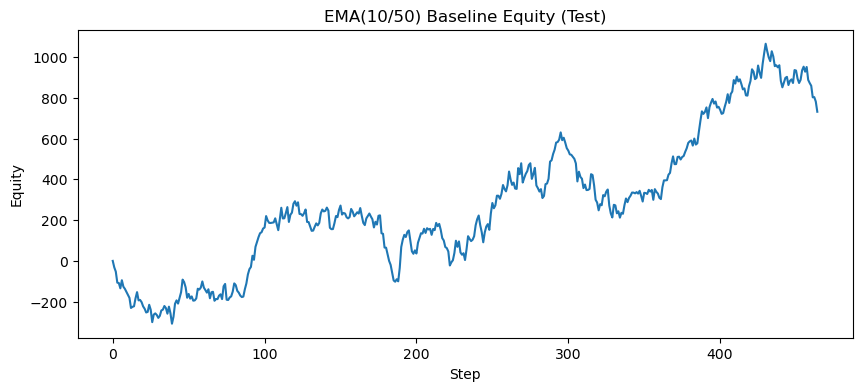

Baseline final equity: 731.6439999999993


In [7]:

def ema_baseline_equity(windows, fast=10, slow=50, cost_points=0.5):
    # Signal from EMA crossover on each 96-win (using last EMA values)
    equity = []
    pos = 0
    eq = 0.0
    prev_signal = 0

    for i in range(len(windows)-1):
        w = windows[i]
        e1, e2 = _ema(w, fast), _ema(w, slow)
        signal = 1 if e1[-1] > e2[-1] else -1

        dP = windows[i+1, -1] - windows[i, -1]
        pnl = dP * pos

        # cost on flips
        cost = cost_points if (signal != prev_signal) else 0.0
        eq += pnl - cost
        equity.append(eq)

        pos = signal
        prev_signal = signal

    return np.array(equity)

eq_base = ema_baseline_equity(df_test, fast=10, slow=50, cost_points=0.5)
plt.plot(eq_base)
plt.title("EMA(10/50) Baseline Equity (Test)"); plt.xlabel("Step"); plt.ylabel("Equity"); plt.show()
print("Baseline final equity:", float(eq_base[-1]) if len(eq_base) else 0.0)


Using cpu device
Logging to ./ppo_v10_tb/PPO_1
-----------------------------
| time/              |      |
|    fps             | 910  |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 1024 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 811         |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 2048        |
| train/                  |             |
|    approx_kl            | 0.009233377 |
|    clip_fraction        | 0.0394      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | 9.17e-05    |
|    learning_rate        | 0.0003      |
|    loss                 | 5.12e+03    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00384    |
|    value_loss           | 1.09e+04    |
-----------------------------

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5000, episode_reward=476.35 +/- 0.00
Episode length: 465.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 465         |
|    mean_reward          | 476         |
| time/                   |             |
|    total_timesteps      | 5000        |
| train/                  |             |
|    approx_kl            | 0.007125109 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -0.00094    |
|    learning_rate        | 0.0003      |
|    loss                 | 2.75e+03    |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.00259    |
|    value_loss           | 6.12e+03    |
-----------------------------------------
New best mean reward!
-----------------------------
| time/              |      |
|    fps             | 612  |
|    iterations      | 5    |
|    time_elap

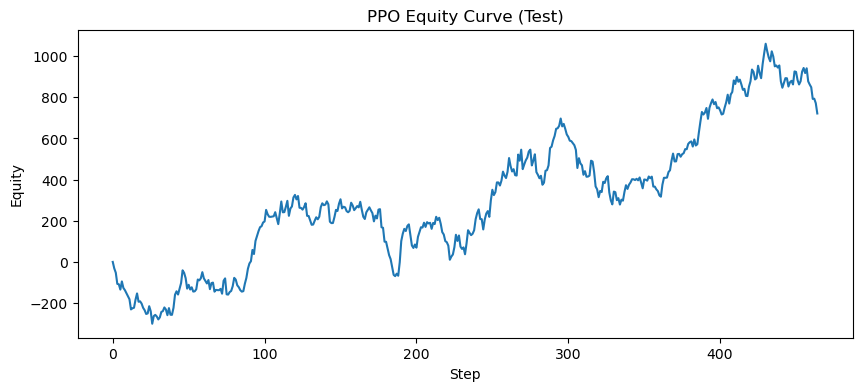

Final equity: 721.4640
Sharpe (approx): 3.72 | MaxDD: 418.5020 | Calmar: 1.72


In [8]:

if SB3_AVAILABLE:
    train_vec = DummyVecEnv([lambda: DayByDay96Env(df_train)])
    val_vec   = DummyVecEnv([lambda: DayByDay96Env(df_val)])
    model = PPO(
        "MlpPolicy",
        train_vec,
        verbose=1,
        n_steps=1024,
        batch_size=256,
        gae_lambda=0.95,
        gamma=0.99,
        learning_rate=3e-4,
        ent_coef=0.0,
        clip_range=0.2,
        tensorboard_log="./ppo_v10_tb/"
    )
    eval_cb = EvalCallback(val_vec, best_model_save_path="./ppo_v10_best", log_path="./ppo_v10_eval", eval_freq=5000)
    model.learn(total_timesteps=200_000, callback=eval_cb)

    # Evaluate on test
    best_model = PPO.load("./ppo_v10_best/best_model")
    obs, _ = test_env.reset()
    done = False
    equity_curve = []
    actions = []
    while not done:
        action, _ = best_model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = test_env.step(int(action))
        equity_curve.append(info["equity"])
        actions.append(int(action))

    equity_curve = np.array(equity_curve)
    plt.plot(equity_curve)
    plt.title("PPO Equity Curve (Test)")
    plt.xlabel("Step"); plt.ylabel("Equity"); plt.show()

    # Simple metrics
    ret = np.diff(np.insert(equity_curve, 0, 0.0))
    sharpe = (ret.mean() / (ret.std() + 1e-12)) * np.sqrt(252*24)  # interpret each row as ~hourly if desired
    dd = np.maximum.accumulate(equity_curve) - equity_curve
    max_dd = dd.max() if len(dd) else 0.0
    calmar = (equity_curve[-1] / (abs(max_dd) + 1e-12)) if max_dd > 1e-12 else np.inf

    print(f"Final equity: {equity_curve[-1]:.4f}")
    print(f"Sharpe (approx): {sharpe:.2f} | MaxDD: {max_dd:.4f} | Calmar: {calmar:.2f}")
else:
    print("Skip PPO section: install stable-baselines3 to train the RL agent.")


In [9]:

def walk_forward_indices(N, train_size=0.6, val_size=0.2, step=500):
    """Yield (train_slice, val_slice, test_slice) index tuples for walk-forward.

    step controls how far we roll forward each iteration.

    Example: for N=3000, train=1800, val=600, test=600 -> windows rolled by 'step'.

    """
    tr = int(N*train_size); va = int(N*val_size); te = N - tr - va
    start = 0
    while start + tr + va + te <= N:
        yield (slice(start, start+tr),
               slice(start+tr, start+tr+va),
               slice(start+tr+va, start+tr+va+te))
        start += step

# Example use (no training here, just showing how you'd iterate):
for (tr, va, te) in walk_forward_indices(len(df96), train_size=0.7, val_size=0.15, step=300):
    print("WF window:", tr, va, te)
    # env_tr = DayByDay96Env(df96.values[tr])
    # env_va = DayByDay96Env(df96.values[va])
    # Train PPO on env_tr, select on env_va, then evaluate on DayByDay96Env(df96.values[te])
    break


WF window: slice(0, 2172, None) slice(2172, 2637, None) slice(2637, 3104, None)



## Notes & Next Steps

- **Costs**: Tune `spread_points`, `slippage_points`, and `commission` in `DayByDay96Env` to match realistic conditions for Volatility 10 Index.
- **Features**: The `build_row_features` function now uses only the 96-window. You can append your domain features (BTMM/SMC/Wyckoff tags) if you have them per row.
- **Actions**: Currently discrete (flat/long/short). For sizing (continuous in [-1,+1]) use SAC/TD3 and map action → exposure.
- **Walk-forward**: Use the template to perform rolling re-trains and strict out-of-sample testing on each segment.
- **Live/Paper**: If you bridge to MT5/Deriv API, *paper trade first*. Never go live off backtests alone.
